In [1]:
import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from SyMBac.PSF import PSF_generator
import tifffile
from skimage.util import img_as_uint
from skimage.transform import resize
import os

In [2]:
pixel_size = 0.05
scale = 1
pixel_size = pixel_size/scale
def simulate_molecule_counting(N_molecules, length, width):
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    true_N_molecules = np.sum(FL_cell)
    return FL_cell, true_N_molecules

In [3]:
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)

In [4]:
OPL_cell_3D = convert_to_3D(OPL_cell)
OPL_cell_3D = np.pad(OPL_cell_3D, ((0,0),(10,10),(10,10)))

In [5]:
def generate_convolved_cell(N_molecules, OPL_cell_3D, kernel):
    
    SNR = 5
    
    weights = [np.sum(x) for x in OPL_cell_3D]
    weights = np.array(weights)/sum(weights)
    layers = np.arange(len(OPL_cell_3D))
    layer_distribution = np.random.choice(layers, p = weights, size = N_molecules)

    
    FL_cell_3D = np.zeros_like(OPL_cell_3D)
    for i in layer_distribution:
        FL_cell_3D[i] += OPL_to_FL(OPL_cell_3D[i], density = 1/np.sum(OPL_cell_3D[i])).astype(np.uint8)
    FL_cell_3D = FL_cell_3D.astype(np.float32)
    
    
    
    while np.sum(FL_cell_3D) != N_molecules:
        
        weights = [np.sum(x) for x in OPL_cell_3D]
        weights = np.array(weights)/sum(weights)
        layers = np.arange(len(OPL_cell_3D))
        layer_distribution = np.random.choice(layers, p = weights, size = N_molecules)
        
        FL_cell_3D = np.zeros_like(OPL_cell_3D)
        for i in layer_distribution:
            FL_cell_3D[i] += OPL_to_FL(OPL_cell_3D[i], density = 1/np.sum(OPL_cell_3D[i])).astype(np.uint8)
        FL_cell_3D = FL_cell_3D.astype(np.float32)
        
        

        
    
    localisation_data = pd.DataFrame(np.argwhere(FL_cell_3D)[:,1:] * (pixel_size * 1000))
    localisation_data.columns = ["y [nm]", "x [nm]"]
    localisation_data["Photon #"] = 2250
    
    conv_FL_cell_3D = np.array([convolve_rescale(cell_layer, PSF_layer, 1, False) for cell_layer, PSF_layer in zip(FL_cell_3D, kernel)])
    
    
    conv_FL_cell = conv_FL_cell_3D.sum(axis=0)
    conv_FL_cell = conv_FL_cell * 85000 * SNR
    conv_FL_cell = np.random.poisson(conv_FL_cell).astype(np.float64)
    bg_noise = np.random.normal(500, 120, conv_FL_cell.shape)
    conv_FL_cell += np.where(bg_noise > 0, bg_noise, 0)
    
    conv_FL_cell = conv_FL_cell/(conv_FL_cell.max())
    conv_FL_cell = img_as_uint(conv_FL_cell)
    return conv_FL_cell, localisation_data
    #plt.imshow(conv_FL_cell, cmap="Greys_r")
    



In [6]:
length = 5
width = 1
OPL_cell_MACS = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D_MACS = convert_to_3D(OPL_cell_MACS)
OPL_cell_3D_MACS = np.pad(OPL_cell_3D_MACS, ((0,0),(10,10),(10,10)))

OPL_cell_3D_MACS = resize(OPL_cell_3D_MACS, (int(round(OPL_cell_3D_MACS.shape[0]*0.6)), int(round(OPL_cell_3D_MACS.shape[1]*1.1)), int(round(OPL_cell_3D_MACS.shape[2])*2)), anti_aliasing=True, clip=False, preserve_range=True)#.astype(int)
OPL_cell_3D_MACS = (OPL_cell_3D_MACS > 0) * 1

In [7]:
OPL_cell_3D_MACS.shape

(11, 132, 80)

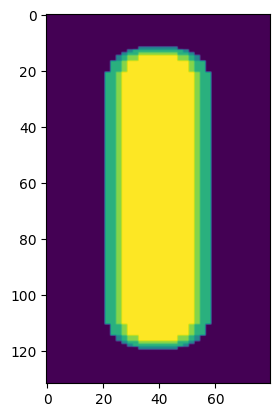

In [8]:
plt.imshow(OPL_cell_3D_MACS.sum(axis=0))

In [9]:
OPL_cell_3D_MACS.shape

(11, 132, 80)

5.168764158287826


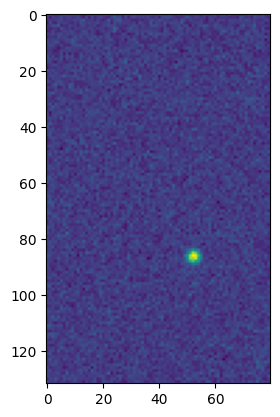

In [10]:
my_kernel = PSF_generator(
    radius = 30, 
    wavelength = 0.55, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pixel_size, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = OPL_cell_3D_MACS.shape[0],
    pz = 0.6,
    working_distance = 170
)
my_kernel.calculate_PSF()
my_kernel.kernel /= np.sum(my_kernel.kernel)


## Check SNR for brightest molecule 
SNRs = []
for _ in range(100):
    frame_data = generate_convolved_cell(N_molecules=1, OPL_cell_3D=OPL_cell_3D_MACS, kernel = np.array([my_kernel.kernel[6]]*my_kernel.kernel.shape[0]))[0]
    SNRs.append(frame_data.max() / frame_data.mean())
    
print(np.mean(SNRs))
plt.imshow(frame_data)

In [11]:
N_molecules_sample = np.repeat(np.arange(1,31), 200)
training_data = np.array([generate_convolved_cell(N_molecules=N, OPL_cell_3D=OPL_cell_3D_MACS, kernel = my_kernel.kernel) for N in tqdm(N_molecules_sample)])
all_cells = np.array([x[0] for x in training_data])

locallisation_data = np.array([x[1] for x in training_data])

for i, data in enumerate(locallisation_data):
    data["frame"] = i+1
directory = "DEEPSTORM_MACS_training_data"
try:
    os.mkdir(directory)
except:
    pass

coordinates = pd.concat(locallisation_data).reset_index(drop=True)
coordinates.index += 1
coordinates.to_csv(f"{directory}/SimulatedDataset.csv")

tifffile.imwrite(f"{directory}/SimulatedDataset.tif", all_cells)

  0%|          | 0/6000 [00:00<?, ?it/s]

/tmp/ipykernel_2056059/2643871225.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_data = np.array([generate_convolved_cell(N_molecules=N, OPL_cell_3D=OPL_cell_3D_MACS, kernel = my_kernel.kernel) for N in tqdm(N_molecules_sample)])
/tmp/ipykernel_2056059/2643871225.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  locallisation_data = np.array([x[1] for x in training_data])


In [12]:
N_molecules_sample = np.repeat(np.arange(1,31), 100)
test_data = np.array([generate_convolved_cell(N_molecules=N, OPL_cell_3D=OPL_cell_3D_MACS, kernel = my_kernel.kernel) for N in tqdm(N_molecules_sample)])
all_cells = np.array([x[0] for x in test_data])

locallisation_data = np.array([x[1] for x in test_data])

for i, data in enumerate(locallisation_data):
    data["frame"] = i+1
directory = "DEEPSTORM_MACS_test_data"
try:
    os.mkdir(directory)
except:
    pass

coordinates = pd.concat(locallisation_data).reset_index(drop=True)
coordinates.index += 1
coordinates.to_csv(f"{directory}/SimulatedDataset.csv")

_ = [tifffile.imwrite(f"{directory}/{str(i+1).zfill(4)}_test.tif", np.array([cell])) for i, cell in enumerate(all_cells)]

  0%|          | 0/3000 [00:00<?, ?it/s]

/tmp/ipykernel_2056059/3092399585.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data = np.array([generate_convolved_cell(N_molecules=N, OPL_cell_3D=OPL_cell_3D_MACS, kernel = my_kernel.kernel) for N in tqdm(N_molecules_sample)])
/tmp/ipykernel_2056059/3092399585.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  locallisation_data = np.array([x[1] for x in test_data])
